# MarMesh - AI Marketing Campaign Automation

**Transform your campaign brief into a complete multi-channel marketing campaign in minutes! Just describe your product and budget - our AI agents handle the rest.**

## For Marketers, By Marketers
✅ **Campaign Strategy** - AI researches your market and creates data-driven strategies  
✅ **Human Approval** - Review and edit all campaign details before execution  
✅ **Content Creation** - Automatically generates video content for your campaigns  
✅ **Multi-Channel Publishing** - Publishes to YouTube, Instagram, TikTok, ... simultaneously  
✅ **Complete Automation** - From brief to live campaign with minimal manual work  

## How It Works
1. **Input:** "Launch energy drink Drex, organic ingredients, 100€ budget"
2. **AI Strategy:** Generates target audience, channels, KPIs, messaging
3. **Your Approval:** Review and tweak the campaign plan
4. **Content Creation:** AI creates promotional video content
5. **Your Final OK:** Approve the creative before it goes live
6. **Auto-Publish:** Deploys across all selected social channels

## Perfect For
- **Small businesses** with limited marketing resources
- **Startups** launching new products quickly
- **Agencies** wanting to scale campaign creation
- **Marketers** who want AI to handle the heavy lifting

*Turn hours of campaign planning into minutes of smart automation!*

# Install dependencies

In [ ]:
%pip install google-adk
%pip install litellm
%pip install google-genai

In [32]:
import os
import re
import json
import time
import requests
import asyncio
from pprint import pprint
import ipywidgets as widgets
from dotenv import load_dotenv
from IPython.display import Markdown, display, clear_output

from google import genai
from google.genai import types
from typing import Any, Dict, Union
from google.adk.tools import LongRunningFunctionTool
from google.adk.agents import Agent, SequentialAgent
from google.genai.types import GenerationConfig
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai.types import Content, Part
from google.adk.tools import google_search
from google.adk.tools.tool_context import ToolContext
from google.adk.models.lite_llm import LiteLlm

from openai import OpenAI

import base64
import subprocess
import fal_client
from pathlib import Path
from IPython.display import Audio as IPAudio
from IPython.display import display, Video as IPVideo
from IPython.display import display, Image as IPImage
from fal_client import upload_file, subscribe, InProgress, submit, result

In [33]:
load_dotenv()

FAL_KEY = os.getenv("FAL_KEY")
os.environ["FAL_KEY"] = FAL_KEY

PERPLEXITY_SONAR_API_KEY=os.getenv("PERPLEXITY_SONAR_API_KEY")
GEMINI_API_KEY=os.getenv("GOOGLE_API_KEY")
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")


if GEMINI_API_KEY and OPENAI_API_KEY and PERPLEXITY_SONAR_API_KEY:
    print("API keys loaded!")
else:
    print("One or more API keys are not loaded!")

llm = LiteLlm(
    model="openai/gpt-4o",
    temperature=0,
    num_retries=0,
    timeout=60,
)

client = OpenAI(api_key=OPENAI_API_KEY, max_retries=1, timeout=6000)

API keys loaded!


In [34]:
# Global dictionary to track pending approvals across the notebook session
PENDING_APPROVALS = {}

## Campaign Advisor Agent

**Role:** Senior Marketing Strategist & Research Coordinator

**What it does:** Takes your product brief and creates a complete, data-driven campaign strategy by researching market trends and synthesizing insights from multiple AI sources.

**Process:**
1. **Research Phase** - Queries both Gemini and Perplexity for market insights, competitor analysis, and strategy recommendations
2. **Synthesis Phase** - Combines all research into a structured campaign plan with target audience, channels, messaging, KPIs, and budget allocation
3. **Validation** - Ensures all critical campaign elements are present before passing to approval

**Output:** Complete campaign strategy ready for human review and approval

*The strategic brain of your marketing automation - transforms basic product info into professional campaign plans backed by AI research.*

In [35]:
client_gemini = genai.Client(api_key=GEMINI_API_KEY)

google_search_tool = types.Tool(google_search=types.GoogleSearch())

def ask_gemini(query: str, tool_context: ToolContext) -> str:

    try:
        response = client_gemini.models.generate_content(
            model="gemini-2.0-flash-lite", #gemini-2.0-flash-exp, gemini-2.5-flash-preview-05-20, gemini-2.0-flash-lite, gemini-2.5-flash-preview-05-20
            config=types.GenerateContentConfig(
                system_instruction="""
                    You are a highly skilled marketing assistant specializing in **product launch campaigns**, with deep knowledge of go-to-market strategy, audience targeting, channel selection, campaign KPIs, and execution planning.

                    You **must** use the `google_search_tool` to validate and enrich your recommendations with up-to-date, relevant data.
                    
                    You will receive a **product launch briefing**. Your task is to:
                    - Perform in-depth research on the ideal target audience.
                    - Recommend the most suitable marketing channels and budget allocations.
                    - Provide a tactical execution plan tailored to the product, market, and stated objectives.
                    
                    Prioritize outcomes that align tightly with product launch goals such as awareness, engagement, acquisition, or early adoption. Suggest additional channels or strategies if they offer clear strategic value.
                    
                    Respond using the following structured format:
                    
                    ---
                    
                    **Campaign Type**: Product Launch
                    
                    **Target Audience**: Research and define ideal personas, demographics, firmographics, or behavioral segments best suited for this product. Consider industry benchmarks and competitor patterns if relevant.
                    
                    **Budget**: **ONLY**, if not provided, suggest budget, do not split it in tiers! Just one suggestion. List which activities are feasible and what realistic outcomes (e.g., reach, leads, conversions) can be expected with that budget.
                    
                    **Duration**: Suggest a campaign duration aligned with industry standards for a product launch (typically 4–12 weeks), but adjust based on product complexity and market readiness.
                    
                    **Channels**: List the top 2 most impactful social media marketing channels for launching this product. For each, justify the selection based on audience alignment and campaign goals. Include content format recommendations (e.g., teaser video, case study, carousel post).
                    
                    **Campaign Message**: If not provided, propose 2 concise, benefit-oriented campaign messages that speak directly to the audience's goals and pain points. Avoid vague or generic language.
                    
                    **Campaign KPIs**: Identify the 3 primary KPIs to evaluate this product launch (e.g., Reach, Engagement, Conversions). These should be platform-agnostic and focused on strategic outcomes.
                    
                    **Success Metrics**: Define specific, quantifiable benchmarks for each KPI. For example, "Reach: 100,000 impressions across launch channels in 4 weeks" or "Conversion Rate: 7% from landing page to free trial sign-up."
                    
                    Your goal is to deliver **actionable, validated** campaign recommendations tailored to the launch’s success.

                """,
                tools=[google_search_tool],
                temperature=0.0
            ),
            contents=query,
        )

        # Get plain text result
        gemini_response = response.text
        
        # Wrap in JSON
        response_json = json.dumps({ "result": gemini_response }, ensure_ascii=False)
        
        # Parse and render in notebook
        # parsed = json.loads(response_json)
        # display(Markdown(parsed["result"]))

        tool_context.state["gemini_answer"] = gemini_response
        
        return gemini_response
    
    except Exception as e:
        return json.dumps({ "error": str(e) })


In [36]:
PERPLEXITY_SONAR_API_ENDPOINT = "https://api.perplexity.ai/chat/completions" 

def ask_perplexity(query: str, tool_context: ToolContext) -> str:

    headers = {
        "Authorization": f"Bearer {PERPLEXITY_SONAR_API_KEY}",
        "Content-Type": "application/json"
    }
    body = {
        "model": "sonar",  # alt: sonar | sonar-deep-research
        "messages": [
            {"role": "system", "content": """
                    You are a highly skilled marketing assistant specializing in **product launch campaigns**, with deep knowledge of go-to-market strategy, audience targeting, channel selection, campaign KPIs, and execution planning.
                    
                    You will receive a **product launch briefing**. Your task is to:
                    - Perform in-depth research on the ideal target audience.
                    - Recommend the most suitable marketing channels and budget allocations.
                    - Provide a tactical execution plan tailored to the product, market, and stated objectives.
                    
                    Prioritize outcomes that align tightly with product launch goals such as awareness, engagement, acquisition, or early adoption. Suggest additional channels or strategies if they offer clear strategic value.
                    
                    Respond using the following structured format:
                    
                    ---
                    
                    **Campaign Type**: Product Launch
                    
                    **Target Audience**: Research and define ideal personas, demographics, firmographics, or behavioral segments best suited for this product. Consider industry benchmarks and competitor patterns if relevant.
                    
                    **Budget**: **ONLY**, if not provided, suggest budget, do not split it in tiers! Just one suggestion. List which activities are feasible and what realistic outcomes (e.g., reach, leads, conversions) can be expected with that budget.
                    
                    **Duration**: Suggest a campaign duration aligned with industry standards for a product launch (typically 4–12 weeks), but adjust based on product complexity and market readiness.
                    
                    **Channels**: List the top 2 most impactful social media marketing channels for launching this product. For each, justify the selection based on audience alignment and campaign goals. Include content format recommendations (e.g., teaser video, case study, carousel post).
                    
                    **Campaign Message**: If not provided, propose 2 concise, benefit-oriented campaign messages that speak directly to the audience's goals and pain points. Avoid vague or generic language.
                    
                    **Campaign KPIs**: Identify the 3 primary KPIs to evaluate this product launch (e.g., Reach, Engagement, Conversions). These should be platform-agnostic and focused on strategic outcomes.
                    
                    **Success Metrics**: Define specific, quantifiable benchmarks for each KPI. For example, "Reach: 100,000 impressions across launch channels in 4 weeks" or "Conversion Rate: 7% from landing page to free trial sign-up."
                    
                    Your goal is to deliver **actionable, validated** campaign recommendations tailored to the launch’s success.

                """},
            {"role": "user", "content": query}
        ],
        "search_recency_filter": "week", #alt: week
        "temperature": 0.0,
    }
    r = requests.post(PERPLEXITY_SONAR_API_ENDPOINT, headers=headers, data=json.dumps(body), timeout=600)
    r.raise_for_status()
    data = r.json()

    answer = data["choices"][0]["message"]["content"]

    # Extract citations
    citations = []
    try:
        for url in data.get("citations", []):
            if isinstance(url, str):
                citations.append(url)
    except Exception as e:
        print(f"Error extracting citations: {e}")

    # print("🔍 Answer:")
    # print(answer)
    
    # print("\n🔗 Sources:")
    # for i, src in enumerate(citations, 1):
    #     print(f"  source {i}: {src}")

    tool_context.state["perplexity_answer"] = answer

    return answer

In [37]:
def synthesize_campaign(tool_context: ToolContext) -> dict:
    """
    Gets gemini and perplexity answers from context, synthesizes them via LLM into clean JSON,
    and stores the result in context for other agents.
    """
    
    # Get the research answers from context
    gemini_answer = tool_context.state.get("gemini_answer")
    perplexity_answer = tool_context.state.get("perplexity_answer")
    input_text = tool_context.state.get("input_text", "Product launch campaign")
    product_image_path = tool_context.state.get("product_image_path")
    
    print(f"🔍 Found gemini_answer: {bool(gemini_answer)}")
    print(f"🔍 Found perplexity_answer: {bool(perplexity_answer)}")
    
    if not gemini_answer or not perplexity_answer:
        return {
            "status": "error",
            "message": "Missing gemini_answer or perplexity_answer in context. Please call ask_gemini and ask_perplexity first."
        }
    
    # Create synthesis prompt for LLM
    synthesis_prompt = f"""
        Based on the research from Gemini and Perplexity below, create a comprehensive campaign strategy JSON.
        
        ORIGINAL USER REQUEST: {input_text}
        
        GEMINI RESEARCH:
        {gemini_answer}
        
        PERPLEXITY RESEARCH:
        {perplexity_answer}
        
        TASK: Synthesize the above research into a single, comprehensive campaign strategy. Return ONLY a clean, valid JSON object (no markdown, no backticks) with this exact structure:
        
        {{
            "campaign_input": "{input_text}",
            "campaign_type": "Product Launch",
            "target_audience": "Synthesized target audience from both research sources",
            "budget": {{
                "budget": "Budget from research or $100 if not specified",
                "activities": "Key activities from research synthesis",
                "expected_outcomes": "Expected outcomes from research"
            }},
            "duration": "Duration from research (e.g., '4 weeks')",
            "channels": [
                {{
                    "name": "Channel name from research",
                    "justification": "Why this channel is effective based on research",
                    "recommended_formats": ["Format 1", "Format 2", "Format 3"]
                }}
            ],
            "campaign_message": {{
                "theme": "Main campaign theme from research",
                "key_messages": [
                    "Message 1 from research",
                    "Message 2 from research", 
                    "Message 3 from research"
                ]
            }},
            "campaign_KPIs": [
                {{"name": "Reach", "success_metric": "Specific metric from research"}},
                {{"name": "Engagement", "success_metric": "Specific metric from research"}},
                {{"name": "Conversion", "success_metric": "Specific metric from research"}}
            ]
        }}
        
        Return only the JSON object, no other text.
        """

    try:
        response = client_gemini.models.generate_content(
            model="gemini-2.0-flash-lite", 
            config=types.GenerateContentConfig(
                system_instruction="You are a JSON synthesis expert. Generate only valid JSON responses with no additional text or formatting.",
                temperature=0.0,
                max_output_tokens=2000
            ),
            contents=synthesis_prompt,
        )
        
        llm_response = response.text.strip()
        
        # Clean and parse the JSON response
        cleaned_json = re.sub(r"^```(?:json)?\s*|```$", "", llm_response.strip(), flags=re.IGNORECASE | re.MULTILINE).strip()
        
        # Extract JSON if mixed with text
        if not cleaned_json.startswith('{'):
            json_match = re.search(r'\{.*\}', cleaned_json, re.DOTALL)
            if json_match:
                cleaned_json = json_match.group(0)
        
        # Parse and validate JSON
        campaign_data = json.loads(cleaned_json)
        
        if not isinstance(campaign_data, dict) or "campaign_input" not in campaign_data:
            raise ValueError("Invalid campaign data structure")

        # Add image path to campaign data if available
        if product_image_path:
            campaign_data["product_image_path"] = product_image_path
            print(f"Added product image path to campaign data: {product_image_path}")
        
        # Store in context for other agents
        tool_context.state["campaign_data"] = campaign_data
        tool_context.state["json_synthesized"] = True
        
        print("✅ Campaign JSON synthesized and stored in context!")
        
        return {
            "status": "success",
            "message": "Campaign JSON successfully synthesized from research and stored in context",
            "campaign_data": campaign_data
        }
        
    except Exception as e:
        print(f"❌ Synthesis failed: {e}")
        return {
            "status": "error",
            "message": f"Failed to synthesize campaign JSON: {e}"
        }

In [38]:
campaign_advisor = Agent(
    name="campaign_advisor",
    model=llm,
    # model="gemini-2.5-flash-preview-05-20",
    description="Analyzes market trends and provides campaign strategy recommendations",
    instruction="""
        You are a senior marketing strategist specializing in **product launch campaigns**.
        Your task is to analyze the product briefing using insights from both the `ask_gemini` and `ask_perplexity` tools and generate a **concrete, actionable campaign execution strategy**.
        
        ### Mandatory Workflow:
        1. **Call both tools**: Always invoke `ask_gemini` and `ask_perplexity` using the campaign briefing as input.
        
        2. **Synthesize research**: After getting responses from both tools, call `synthesize_campaign` to create clean campaign JSON from the research.
        
        3. **Handle missing data**: If either tool does not return valid information, **immediately stop** and respond with:
           `"I wasn't able to gather enough information to generate a campaign execution strategy."`
        
        ### After calling all tools: STOP
    """,
    tools=[ask_gemini, ask_perplexity, synthesize_campaign],
)

## Campaign Approver Agent

**Role:** Human-in-the-Loop Gateway & Workflow Controller

**What it does:** Creates an interactive approval interface where you can review, edit, and approve the AI-generated campaign strategy before execution.

**Process:**
1. **Display Campaign Form** - Shows editable campaign details including target audience, channels, messaging, budget, and KPIs
2. **Human Review** - Pauses workflow while you review and modify any campaign elements
3. **Approval Gate** - Waits for your "Confirm & Save" or "Reject" decision
4. **Auto-Resume** - Automatically continues workflow after approval with your edited campaign data

**Key Feature:** **Editable Interface** - You can modify target audience, adjust messaging, change channels, or update budget before approving

**Output:** User-approved campaign strategy with any modifications, ready for content creation

*Your quality control checkpoint - ensures every campaign meets your standards before going live.*

In [39]:
def campaign_approval_form(tool_context: ToolContext) -> dict:
    """
    Long running function that displays campaign approval form and returns initial status.
    The agent execution will pause after this function returns.
    
    Args:
        tool_context: Tool context for state management
    
    Returns:
        dict: Initial status with approval_id for tracking
    """
    
    campaign_data = tool_context.state.get("campaign_data")
    
    if not campaign_data:
        return {
            "status": "error",
            "message": "No campaign data found in tool context"
        }
    
    if not isinstance(campaign_data, dict):
        return {
            "status": "error",
            "message": "Campaign data is not a valid dictionary"
        }

    print("✅ Successfully retrieved campaign_data from context!")
    
    # Generate approval ID and store in global state
    approval_id = f"approval_{int(time.time())}"
    
    # Store approval details in global state (accessible across async functions)
    PENDING_APPROVALS[approval_id] = {
        "status": "pending",
        "campaign_data": campaign_data,  # This will be updated with user edits
        "created_at": time.time()
    }
    
    # Store in tool context for tracking
    tool_context.state["approval_id"] = approval_id
    tool_context.state["approval_status"] = "pending"
    
    # Display the interactive form
    display_campaign_form_for_approval(campaign_data, approval_id)
    
    # Return initial status - this causes ADK to pause agent execution
    print(f"🛑 Agent execution will now pause. Approval ID: {approval_id}")
    return {
        "status": "pending",
        "approval_id": approval_id,
        "message": "Campaign form displayed. Agent execution paused until approval.",
    }

def display_campaign_form_for_approval(campaign_data: dict, approval_id: str):
    """
    Display the interactive campaign form with widgets for user approval.
    """
    
    # --- Widgets ---
    readonly_campaign_type = widgets.Text(
        value=campaign_data.get("campaign_type", ""), 
        description='Type:', 
        disabled=True
    )

    target_audience_input = widgets.Textarea(
        value=campaign_data.get("target_audience", ""), 
        description='Target Audience:',
        layout=widgets.Layout(width='100%', height='80px'),
    )
    
    duration_input = widgets.Text(
        value=campaign_data.get("duration", ""), 
        description='Duration:'
    )
    
    budget_data = campaign_data.get("budget", {})
    budget_input = widgets.Text(
        value=budget_data.get("budget", "") if isinstance(budget_data, dict) else str(budget_data), 
        description='Budget:'
    )

    # File path as readonly
    readonly_file_path = widgets.Text(
        value=campaign_data.get("product_image_path", ""), 
        description='File:', 
        disabled=True
    )

    # Campaign Message
    campaign_message = campaign_data.get("campaign_message", {})
    theme = campaign_message.get("theme", "") if isinstance(campaign_message, dict) else ""
    key_messages = campaign_message.get("key_messages", []) if isinstance(campaign_message, dict) else []
    
    theme_and_messages = "\n".join([theme] + (key_messages if isinstance(key_messages, list) else []))
    
    campaign_message_input = widgets.Textarea(
        value=theme_and_messages,
        description='Message:',
        layout=widgets.Layout(width='100%', height='100px')
    )

    # Channels (editable name, readonly details)
    channel_name_inputs = []
    channel_justifications = []
    channel_formats = []

    channels = campaign_data.get("channels", [])
    if isinstance(channels, list):
        for ch in channels:
            if isinstance(ch, dict):
                name_input = widgets.Text(value=ch.get("name", ""), description="Channel:")
                justification_text = ch.get("justification", "")
                formats_list = ch.get("recommended_formats", [])
                formats_text = "\n".join(formats_list if isinstance(formats_list, list) else [])

                channel_name_inputs.append(name_input)
                channel_justifications.append(justification_text)
                channel_formats.append(formats_text)

    # KPIs and Success Metrics
    kpi_widgets = []
    kpis = campaign_data.get("campaign_KPIs", [])
    if isinstance(kpis, list):
        for kpi in kpis:
            if isinstance(kpi, dict):
                kpi_name = widgets.Text(value=kpi.get("name", ""), description="KPI:")
                kpi_metric = widgets.Textarea(
                    value=kpi.get("success_metric", ""),
                    description="Metric:",
                    layout=widgets.Layout(width='100%', height='60px')
                )
                kpi_widgets.append((kpi_name, kpi_metric))

    # Confirm + Output
    confirm_button = widgets.Button(
        description="✅ Confirm & Save",
        button_style='success'
    )
    reject_button = widgets.Button(
        description="❌ Reject",
        button_style='danger'
    )
    output = widgets.Output()

    # --- Save callback ---
    def on_confirm_clicked(b):
        nonlocal campaign_data
        
        print("🔘 Button clicked! Processing approval...")
        
        # Update campaign message
        theme_lines = campaign_message_input.value.strip().splitlines()
        if "campaign_message" not in campaign_data:
            campaign_data["campaign_message"] = {}
        campaign_data["campaign_message"]["theme"] = theme_lines[0] if theme_lines else ""
        campaign_data["campaign_message"]["key_messages"] = theme_lines[1:] if len(theme_lines) > 1 else []


        # Update other fields
        campaign_data["target_audience"] = target_audience_input.value.strip()
        campaign_data["duration"] = duration_input.value
        if "budget" not in campaign_data:
            campaign_data["budget"] = {}
        if isinstance(campaign_data["budget"], dict):
            campaign_data["budget"]["budget"] = budget_input.value

        # Update channels - only keep channels with non-empty names
        original_channels = campaign_data.get("channels", [])
        updated_channels = []
        for idx, name_widget in enumerate(channel_name_inputs):
            if name_widget.value.strip():  # Only include if channel name is not empty
                if idx < len(original_channels) and isinstance(original_channels[idx], dict):
                    channel_data = original_channels[idx].copy()
                    channel_data["name"] = name_widget.value.strip()
                    updated_channels.append(channel_data)
        campaign_data["channels"] = updated_channels

        # Update KPIs - only keep KPIs with non-empty names
        updated_kpis = []
        for name, metric in kpi_widgets:
            if name.value.strip():  # Only include if KPI name is not empty
                updated_kpis.append({
                    "name": name.value.strip(), 
                    "success_metric": metric.value.strip()
                })
        campaign_data["campaign_KPIs"] = updated_kpis

        # Update global approval status
        if approval_id in PENDING_APPROVALS:
            PENDING_APPROVALS[approval_id]["status"] = "approved"
            PENDING_APPROVALS[approval_id]["campaign_data"] = campaign_data
            PENDING_APPROVALS[approval_id]["approved_at"] = time.time()
        
        print(f"✅ Campaign approved! Approval ID: {approval_id}")

        with output:
            clear_output()
            print("✅ Campaign configuration updated and approved!")
            print("⚠️ Agent execution is still paused. Call resume_workflow() to continue.")
            print(f"Approval ID: {approval_id}")
            print(json.dumps(campaign_data, indent=2))

        # Disable buttons to prevent multiple clicks
        confirm_button.disabled = True
        reject_button.disabled = True
        confirm_button.description = "✅ Approved!"


    def on_reject_clicked(b):
        # Update global approval status
        if approval_id in PENDING_APPROVALS:
            PENDING_APPROVALS[approval_id]["status"] = "rejected"
            PENDING_APPROVALS[approval_id]["rejected_at"] = time.time()
        
        print(f"❌ Campaign rejected! Approval ID: {approval_id}")

        with output:
            clear_output()
            print("❌ Campaign configuration rejected!")
            print("⚠️ Agent execution is still paused. The workflow has been terminated.")

        # Disable buttons
        confirm_button.disabled = True
        reject_button.disabled = True
        reject_button.description = "❌ Rejected!"

    confirm_button.on_click(on_confirm_clicked)
    reject_button.on_click(on_reject_clicked)

    # --- Display UI ---
    display(widgets.HTML("<h3>✏️ Campaign Approval Required</h3>"))
    display(widgets.HTML(f"<p><i>Approval ID: <strong>{approval_id}</strong></i></p>"))
    display(widgets.HTML("<p><i>Please review the campaign details below, make any necessary edits, then click 'Confirm & Save' or 'Reject'.</i></p>"))
    
    display(readonly_campaign_type)
    display(duration_input)
    display(readonly_file_path)

    display(widgets.HTML("<h4>🎯 Target Audience</h4>"))
    display(target_audience_input)

    # Budget section
    display(widgets.HTML("<h4>💰 Budget</h4>"))
    display(budget_input)
    
    # Display activities and outcomes as plain text below budget
    budget_data = campaign_data.get("budget", {})
    if isinstance(budget_data, dict):
        activities = budget_data.get("activities", "")
        outcomes = budget_data.get("expected_outcomes", "")
        if activities:
            display(widgets.HTML(f"<p><strong>Activities:</strong><br>{activities}</p>"))
        if outcomes:
            display(widgets.HTML(f"<p><strong>Expected Outcomes:</strong><br>{outcomes}</p>"))

    # Campaign message
    display(widgets.HTML("<h4>📝 Campaign Message</h4>"))
    display(campaign_message_input)

    # Channels
    if channel_name_inputs:
        display(widgets.HTML("<h4>📺 Channels</h4>"))
        for idx, name_input in enumerate(channel_name_inputs):
            display(name_input)
            # Display justification and formats as plain text below each channel
            if idx < len(channel_justifications) and channel_justifications[idx]:
                display(widgets.HTML(f"<p><strong>Justification:</strong><br>{channel_justifications[idx]}</p>"))
            if idx < len(channel_formats) and channel_formats[idx]:
                display(widgets.HTML(f"<p><strong>Formats:</strong><br>{channel_formats[idx]}</p>"))
            display(widgets.HTML("<hr>"))  # Separator between channels

    # KPIs
    if kpi_widgets:
        display(widgets.HTML("<h4>📊 KPIs and Success Metrics</h4>"))
        for name, metric in kpi_widgets:
            display(name, metric)

    # Final controls
    display(widgets.HBox([confirm_button, reject_button]))
    display(output)

In [40]:
# Create the long-running tool for campaign approval
campaign_approval_tool = LongRunningFunctionTool(func=campaign_approval_form)

campaign_approver = Agent(
    name="campaign_approver",
    model=llm,
    description="Prepares campaign data for user review and waits for approval.",
    instruction="""
        You are responsible for getting user approval for the campaign plan created by the previous agent.
        
        The campaign_data from the previous agent should be available in the context state.
        
        Your task:
        1. Get the campaign_data from context and convert it to JSON string if needed
        2. Call the `campaign_approval_tool` tool to obtain campaing approval
        3. The tool will pause execution and wait for user approval
        4. When the workflow resumes after approval, acknowledge the approval and pass control to the next agent
        
        After the workflow resumes with approval, simply acknowledge that the campaign has been approved 
        and is ready for the next step.
    """,
    tools=[campaign_approval_tool]
)

## Campaign Content Creator Agent

**Role:** AI Video Production Studio

**What it does:** Transforms your approved campaign strategy into professional video content using cutting-edge AI tools for image generation, animation, and audio production.

**Process:**
1. **Script Generation** - Creates detailed prompts for visual scenes based on your campaign messaging
2. **Image Creation** - Uses Flux Pro AI to generate high-quality product and lifestyle images
3. **Video Animation** - Animates images into dynamic video scenes with Kling 2.1 Master
4. **Video Assembly** - Concatenates all scenes into a cohesive campaign video
5. **Audio Production** - Generates professional voiceover and background music with Lyria
6. **Final Production** - Merges video and audio into broadcast-ready content

**Output:** Complete promotional video file ready for multi-channel publishing

*Your AI creative team - handles the entire video production pipeline from concept to final cut, no video editing skills required.*

In [41]:
def clean_json_block(content: str) -> str:
    content = re.sub(r"^```json|```$", "", content.strip(), flags=re.IGNORECASE).strip()
    return content.strip("`").strip()

def image_and_video_prompts_generator(tool_context: ToolContext) -> str:
    campaign_data = tool_context.state.get("campaign_data", {})

    campaign_input = campaign_data.get("campaign_input", "")
    target_audience = campaign_data.get("target_audience", "")
    campaign_message = campaign_data.get("campaign_message", {}).get("theme", "")

    if not campaign_input or not target_audience or not campaign_message:
        return "Error: Missing required campaign data (campaign_input, target_audience, or campaign_message)."

    system_prompt = f"""
        You are a creative director collaborating with Flux Pro (image-to-image generation) and Kling 2.1 (image-to-video generation).
        
        Your goal is to produce:
        1. 3 **very detailed and explicit image-to-image prompts** for Flux Pro.
        2. 3 **matching video animation prompts** for Kling 2.1 based on those images.
        
        ---
        
        You must carefully analyze the following product and campaign context, and tailor all prompts specifically for it:
        
        Product Description:
        {campaign_input}
        
        Target Audience:
        {target_audience}
        
        Campaign Theme:
        {campaign_message}
        
        ---
        
        ### 🎨 Image-to-Image Prompt Instructions (Flux Pro)
        - Each prompt should describe a **single scene** centered around this product.
        - The product look and positioning must remain consistent across prompts.
        - Include all of the following:
          - Foreground subject
          - Product materials, reflections, condensation if applicable
          - Camera angle (e.g., front-facing, low-angle)
          - Lighting direction and style (e.g., soft ambient, rim light)
          - Background and environment details (urban, natural, energetic, etc.)
          - Color palette
          - Vibe or emotional tone (e.g., refreshing, bold, natural)
          - Spatial composition (e.g., leave space above, centered, etc.)
        
        ---
        
        ### 🎥 Video Prompt Instructions (Kling 2.1)
        Each video prompt must animate the corresponding image prompt. Be creative and fun and produce varied full of action prompts!
        - Must include the following in detail:
          - **Action** (e.g. mist swirling, bursting effects .. be creative and fun and produce varied full of action prompts suitable for the product. Use soft lighting transitions)
          - **Environment behavior** (e.g., fog rolls, neon pulses)
          - **Camera movement** (e.g., slow zoom out, orbiting pan)
          - **Lighting effects** (e.g., rim glow intensifies, flickering highlights)
          - **Atmospheric elements** (e.g., ambient particles, steam, rain)
          - Keep motion smooth, high quality, and cinematic
          - End each scene with the product fully visible and aesthetically framed
          - Absolutely **no characters** or distortions
        
        ---
        
        ### 🔁 Scene Continuity Instructions
        - Scenes should not be sequential but must **share visual continuity**.
        - Do not add any other text elements to the product
        - Maintain brand and product look across all 3 prompts.
        
        ---
        
        ### ✅ Output Format
        Return a JSON object in this format:
        {{
          "image_prompt_1": "provide image prompt 1 here",
          "video_prompt_1": "provide video prompt 1 here",
          "image_prompt_2": "provide image prompt 2 here",
          "video_prompt_2": "provide video prompt 2 here",
          "image_prompt_3": "provide image prompt 3 here",
          "video_prompt_3": "provide video prompt 3 here"
        }}
        """

    user_prompt = "Generate 3 image-to-image prompts and 3 matching video prompts based on the campaign details above."

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.8,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
        )

        content = response.choices[0].message.content.strip()
        cleaned = clean_json_block(content)
        prompt_data = json.loads(cleaned)

        for i in range(1, 4):
            image_prompt = prompt_data.get(f"image_prompt_{i}", "")
            video_prompt = prompt_data.get(f"video_prompt_{i}", "")

            tool_context.state[f"image_prompt_{i}"] = image_prompt
            tool_context.state[f"video_prompt_{i}"] = video_prompt

            print(f"\n🖼️ Image Prompt {i}:\n{image_prompt}\n")
            print(f"🎥 Video Prompt {i}:\n{video_prompt}\n")

        return "Successfully generated and stored 3 image prompts and 3 video prompts."

    except json.JSONDecodeError as je:
        return f"Error parsing JSON from model response: {je}"
    except Exception as e:
        return f"Error generating prompts: {e}"


In [42]:
def image_to_image_generator_flux_pro(tool_context: ToolContext) -> str:
    """
    Generates 3 images using Flux Pro's image-to-image model based on prompts and the base product image.
    Saves each image locally and stores their paths in the tool context.
    """
    campaign_data = tool_context.state.get("campaign_data", {})
    image_path = campaign_data.get("product_image_path")

    if not image_path or not os.path.isfile(image_path):
        return "❌ Missing or invalid product image path."

    print(f"📦 Using base product image: {image_path}\n")

    try:
        # Upload the image to Flux Pro's file storage
        image_url = upload_file(image_path)

        # Loop through 3 prompts
        for i in range(1, 4):
            image_prompt = tool_context.state.get(f"image_prompt_{i}", "")
            if not image_prompt:
                return f"❌ Missing image_prompt_{i} in tool_context."

            print(f"\n🎨 Generating image {i} with prompt:\n{image_prompt}\n")

            output_filename = f"flux_pro_image2image_output_{i}.png"
            output_path = os.path.join(os.getcwd(), output_filename)

            # Submit generation request
            handler = submit(
                "fal-ai/flux-pro/kontext",
                arguments={
                    "prompt": image_prompt,
                    "image_url": image_url,
                    "seed": 123456,
                    "guidance_scale": 15.0,
                    "num_images": 1,
                    "sync_mode": True,
                    "safety_tolerance": "2",
                    "output_format": "png",
                    "aspect_ratio": "1:1",
                    "image_prompt_strength": 0.85
                }
            )

            # Get result
            result_data = result("fal-ai/flux-pro/kontext", handler.request_id)
            image_info = result_data["images"][0]
            generated_url = image_info.get("url")

            if not generated_url:
                return f"❌ No image URL returned for image {i}."

            # Download the image content
            if generated_url.startswith("data:image"):
                _, encoded = generated_url.split(",", 1)
                image_bytes = base64.b64decode(encoded)
            else:
                response = requests.get(generated_url)
                response.raise_for_status()
                image_bytes = response.content

            # Save to disk
            with open(output_path, "wb") as f:
                f.write(image_bytes)

            # Display in notebook
            try:
                display(IPImage(filename=output_path))
            except Exception:
                print("⚠️ Could not display image in notebook.")

            # Save result in context
            tool_context.state[f"image_scene_{i}_path"] = output_path

        return "✅ Successfully generated and saved all 3 images from Flux Pro."

    except Exception as e:
        return f"❌ Error during Flux Pro generation: {e}"


In [43]:
def image_to_video_generator_kling_2_1_master(tool_context: ToolContext) -> str:
    """
    Generates 3 videos using Kling 2.1 based on prompts and images stored in the tool_context.
    Stores each resulting video path in `scene_{i}_video_path`.
    """

    try:
        for i in range(1, 4):
            video_prompt = tool_context.state.get(f"video_prompt_{i}")
            image_path = tool_context.state.get(f"image_scene_{i}_path")

            if not video_prompt or not image_path or not os.path.isfile(image_path):
                return f"❌ Missing valid video_prompt_{i} or image_scene_{i}_path."

            print(f"🎥 Uploading image for Scene {i} to FAL...")
            uploaded_url = upload_file(image_path)

            def on_queue_update(update):
                if isinstance(update, InProgress):
                    for log in update.logs:
                        print(log["message"])

            print(f"🚀 Submitting Scene {i} video request to Kling 2.1...")
            result = subscribe(
                "fal-ai/kling-video/v2.1/master/image-to-video",
                arguments={
                    "prompt": video_prompt,
                    "image_url": uploaded_url,
                    "duration": "5",
                    "aspect_ratio": "1:1",
                    "negative_prompt": "blurry, distorted, unrealistic hands, warped faces, glitchy movement, pixelated, low quality, jerky camera, unmentioned characters, unnatural lighting",
                    "cfg_scale": 0.9,
                },
                with_logs=True,
                on_queue_update=on_queue_update,
            )

            video_url = result.get("video", {}).get("url")
            if not video_url:
                return f"❌ No video URL returned for scene {i}."

            response = requests.get(video_url)
            response.raise_for_status()

            video_path = os.path.join(os.getcwd(), f"scene_{i}_video.mp4")
            with open(video_path, "wb") as f:
                f.write(response.content)

            try:
                display(IPVideo(video_path))
            except Exception:
                print(f"⚠️ Scene {i}: Could not display video in notebook.")

            tool_context.state[f"scene_{i}_video_path"] = video_path
            # tool_context.state["video_path"] = video_path  # optional global reference

        return "✅ Successfully generated and saved all 3 videos from Kling 2.1."

    except Exception as e:
        return f"❌ Error during Kling 2.1 video generation: {e}"


In [44]:
def get_video_resolution(video_path):
    """Get video resolution using ffprobe"""
    try:
        result = subprocess.run([
            "ffprobe", "-v", "quiet", "-print_format", "json", 
            "-show_streams", "-select_streams", "v:0", video_path
        ], capture_output=True, text=True, check=True)
        
        data = json.loads(result.stdout)
        stream = data['streams'][0]
        width = int(stream['width'])
        height = int(stream['height'])
        return width, height
    except Exception as e:
        print(f"❌ Error getting resolution for {video_path}: {e}")
        return None, None

def concatenate_videos(tool_context: ToolContext) -> str:
    """
    Smart concatenation that detects resolutions and scales to match the first video.
    """
    
    # Get video paths
    scene_1 = tool_context.state.get("scene_1_video_path")
    scene_2 = tool_context.state.get("scene_2_video_path")
    scene_3 = tool_context.state.get("scene_3_video_path")

    if not all([scene_1, scene_2, scene_3]):
        return "❌ Missing one or more scene video paths."

    for path in [scene_1, scene_2, scene_3]:
        if not Path(path).is_file():
            return f"❌ File not found: {path}"

    try:
        # Get resolutions of all videos
        print("🔍 Detecting video resolutions...")
        w1, h1 = get_video_resolution(scene_1)
        w2, h2 = get_video_resolution(scene_2)
        w3, h3 = get_video_resolution(scene_3)
        
        if None in [w1, h1, w2, h2, w3, h3]:
            return "❌ Failed to detect video resolutions"
        
        # Use first video's resolution as target
        target_width, target_height = w1, h1
        print(f"Target resolution: {target_width}x{target_height}")
        
        # Check if all videos have same resolution
        if (w1, h1) == (w2, h2) == (w3, h3):
            print("✅ All videos have same resolution - simple concat")
            filter_complex = "[0:v][1:v][2:v]concat=n=3:v=1:a=0[outv]"
        else:
            print("🔄 Different resolutions detected - scaling to match first video")
            # Scale all videos to first video's resolution with padding
            filter_complex = (
                f"[0:v]scale={target_width}:{target_height}:force_original_aspect_ratio=decrease,"
                f"pad={target_width}:{target_height}:(ow-iw)/2:(oh-ih)/2[v0];"
                f"[1:v]scale={target_width}:{target_height}:force_original_aspect_ratio=decrease,"
                f"pad={target_width}:{target_height}:(ow-iw)/2:(oh-ih)/2[v1];"
                f"[2:v]scale={target_width}:{target_height}:force_original_aspect_ratio=decrease,"
                f"pad={target_width}:{target_height}:(ow-iw)/2:(oh-ih)/2[v2];"
                f"[v0][v1][v2]concat=n=3:v=1:a=0[outv]"
            )
        
        # Run ffmpeg with dynamic filter
        output_path = os.path.join(os.getcwd(), "concatenated_video.mp4")
        
        print("🎬 Running ffmpeg concatenation...")
        subprocess.run([
            "ffmpeg",
            "-i", scene_1,
            "-i", scene_2,
            "-i", scene_3,
            "-filter_complex", filter_complex,
            "-map", "[outv]",
            "-preset", "veryfast",
            "-y", output_path
        ], check=True)
        
        if not Path(output_path).is_file():
            return "❌ Failed to create concatenated video."
        
        tool_context.state["concatenated_video_path"] = output_path
        return f"✅ Successfully concatenated video at {output_path} (resolution: {target_width}x{target_height})"
        
    except subprocess.CalledProcessError as e:
        return f"❌ FFmpeg error: {e}"
    except Exception as e:
        return f"❌ Unexpected error: {e}"


In [45]:
def text_to_audio_generator_lyria(_: str, tool_context: ToolContext) -> str:
    """
    Generates 30s of music from the combined video prompts using Lyria 2.
    Saves the audio to `lyria_output.wav` and updates `audio_path` in the tool_context.
    """

    # Extract and concatenate the prompts
    prompt_1 = tool_context.state.get("video_prompt_1", "")
    prompt_2 = tool_context.state.get("video_prompt_2", "")
    prompt_3 = tool_context.state.get("video_prompt_3", "")
    combined_prompt = f"{prompt_1} {prompt_2} {prompt_3}".strip()

    if not combined_prompt:
        return "❌ Error: No video prompts available to build audio prompt."

    # Use LLM to summarize into music-style prompt
    print("\n🧠 Summarizing scenes into Lyria-compatible prompt...")
    llm_prompt = f"""
        Given the following scene descriptions, generate a single concise prompt suitable for generating a 30s musical soundtrack using Google's Lyria 2.
        
        Focus on:
        - Genre/style
        - Mood/emotion
        - Instruments
        - Tempo
        - Atmosphere
        
        Avoid camera details or character actions. Keep it under 300 characters.
        
        Scenes:
        {combined_prompt}
        """
        
    # Replace this with your own OpenAI client if needed
    summary_response = OpenAI().chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": llm_prompt}],
                temperature=0.7
            )
    music_prompt = summary_response.choices[0].message.content.strip()

    print("\n🎼 Generating music with Lyria 2...\nPrompt:\n", music_prompt)

    try:
        def on_queue_update(update):
            if isinstance(update, InProgress):
                for log in update.logs:
                    print(log["message"])

        result = subscribe(
            "fal-ai/lyria2",
            arguments={
                "prompt": music_prompt,
                "negative_prompt": "vocals, dissonance, low quality, harsh noise"
            },
            with_logs=True,
            on_queue_update=on_queue_update,
        )

        audio_url = result.get("audio", {}).get("url")
        if not audio_url:
            return "❌ Failed to retrieve audio URL from Lyria."

        response = requests.get(audio_url)
        response.raise_for_status()

        audio_path = os.path.join(os.getcwd(), "lyria_output.wav")
        with open(audio_path, "wb") as f:
            f.write(response.content)

        try:
            IPAudio(audio_path)
        except Exception:
            print("⚠️ Could not display audio in notebook.")

        tool_context.state["audio_prompt"] = music_prompt
        tool_context.state["audio_path"] = audio_path

        return f"✅ Music successfully generated and saved at {audio_path}"

    except Exception as e:
        return f"❌ Error generating music with Lyria 2: {e}"


def merge_video_and_audio(_: str, tool_context: ToolContext) -> str:
    """
    Uses FFmpeg to layer 30s Lyria music over a 30s final video.
    Saves to `final_video_with_audio.mp4` and updates `tool_context.state`.
    """

    video_path = tool_context.state.get("concatenated_video_path")
    audio_path = tool_context.state.get("audio_path")

    if not video_path or not audio_path:
        return "❌ Missing video or audio path."

    if not Path(video_path).is_file():
        return f"❌ Video not found: {video_path}"
    if not Path(audio_path).is_file():
        return f"❌ Audio not found: {audio_path}"

    output_path = os.path.join(os.getcwd(), "final_video_with_audio.mp4")

    try:
        subprocess.run([
            "ffmpeg",
            "-i", video_path,
            "-i", audio_path,
            "-shortest",
            "-c:v", "copy",
            "-c:a", "aac",
            "-b:a", "192k",
            "-y", output_path
        ], check=True)

        if not Path(output_path).is_file():
            return "❌ Failed to create final video with audio."

        tool_context.state["final_video_with_audio"] = output_path
        return f"✅ Final video with audio is created and saved at {output_path}"

    except subprocess.CalledProcessError as e:
        return f"❌ FFmpeg error: {e}"
    except Exception as e:
        return f"❌ Unexpected error: {e}"


In [47]:
campaign_content_creator = Agent(
    name="campaign_content_creator",
    model=llm,
    description="Generates campaign content and confirms it.",
    instruction="""
        You are a video creation agent. Your job is to create a sequence of animated scenes from a user's theme using Flux Pro and Kling 2.1 Master.
        
        Follow this **exact sequence**:

        1. Call `image_and_video_prompts_generator` and to generate the image and video prompts.
        
        2. Call `image_to_image_generator_flux_pro` to create the images to be animated.
        
        3. Call `image_to_video_generator_kling_2_1_master` to animate the images into short videos.
        
        4. Call `concatenate_videos` to merge the three scenes into one video.

        5. Call `text_to_audio_generator_lyria` to create audio for the final video.

        6. Call `merge_video_and_audio` to create end result which is the produced video clip (video and audio).
        
        🎬 After this, STOP.
        
        ### Return:
        - The full set of prompts from step 1.
    """,
    tools=[image_and_video_prompts_generator, 
           image_to_image_generator_flux_pro, 
           image_to_video_generator_kling_2_1_master,
           concatenate_videos,
           text_to_audio_generator_lyria,
           merge_video_and_audio
          ],
)

## Campaign Content Approver Agent

**Role:** Creative Quality Control & Publishing Gateway

**What it does:** Displays the AI-generated video content for your final review and approval before it goes live across social channels.

**Process:**
1. **Content Preview** - Shows the completed video with audio in an interactive player
2. **Human Review** - Pauses workflow while you watch and evaluate the creative content
3. **Publishing Decision** - Waits for your "Approve & Publish" or "Reject" choice
4. **Auto-Resume** - Automatically proceeds to publishing after approval or stops workflow if rejected

**Key Feature:** **Video Preview Interface** - Watch the complete campaign video before it's published to ensure quality and brand alignment

**Output:** Approved video content ready for multi-channel distribution, or workflow termination if rejected

*Your final creative checkpoint - ensures every piece of content represents your brand perfectly before going public.*

In [48]:
def content_approval_form(tool_context: ToolContext) -> dict:
    """
    Long running function that displays content approval form and returns initial status.
    NOW USES THE SAME PENDING_APPROVALS DICTIONARY AS CAMPAIGN APPROVAL.
    """

    video_path = tool_context.state.get("final_video_with_audio")
    print(f"🎥 Video path from context: {video_path}")
    
    if not video_path:
        # Check for alternative keys in context
        print("🔍 Checking for alternative video path keys in context...")
        print(f"🔍 Available context keys: {list(tool_context.state.keys())}")
        
        return {
            "status": "error",
            "message": "No video path found in context. Available keys: " + str(list(tool_context.state.keys()))
        }
    
    # Generate approval ID and store in SAME global state as campaign approval
    approval_id = f"approval_{int(time.time())}"
    
    PENDING_APPROVALS[approval_id] = {
        "status": "pending",
        "video_path": video_path,    # Content-specific data
        "created_at": time.time()
    }
    
    # Store in tool context for tracking
    tool_context.state["approval_id"] = approval_id
    tool_context.state["approval_status"] = "pending"
    
    # Display the interactive approval form
    display_content_approval_form(video_path, approval_id)
    
    # Return initial status - this causes ADK to pause agent execution
    print(f"🛑 Agent execution will now pause. Content Approval ID: {approval_id}")
    return {
        "status": "pending",
        "approval_id": approval_id,
        "message": "Content approval form displayed. Agent execution paused until approval.",
        "video_path": video_path
    }

def display_content_approval_form(video_path: str, approval_id: str):
    """
    Display the interactive content approval form with video preview and buttons.
    UPDATED TO USE PENDING_APPROVALS.
    """
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    import os
    
    # Display video preview
    video_display = widgets.HTML()
    
    # Check if video file exists
    if os.path.exists(video_path):
        video_html = f"""
        <div style="text-align: center; margin: 20px 0;">
            <h4>📹 Generated Content Preview</h4>
            <video width="400" height="300" controls>
                <source src="{video_path}" type="video/mp4">
                Your browser does not support the video tag.
            </video>
            <p><strong>Video Path:</strong> {video_path}</p>
        </div>
        """
        video_display.value = video_html
    else:
        video_display.value = f"""
        <div style="text-align: center; margin: 20px 0;">
            <h4>📹 Generated Content</h4>
            <p><strong>Video Path:</strong> {video_path}</p>
            <p><em>Video preview not available</em></p>
        </div>
        """
    
    # Approval buttons
    confirm_button = widgets.Button(
        description="✅ Approve & Publish",
        button_style='success',
        layout=widgets.Layout(width='200px', height='50px')
    )
    reject_button = widgets.Button(
        description="❌ Reject",
        button_style='danger',
        layout=widgets.Layout(width='200px', height='50px')
    )
    output = widgets.Output()
    
    # Button click handlers - UPDATED TO USE PENDING_APPROVALS
    def on_confirm_clicked(b):
        print("🔘 Content approved! Processing...")
        
        # Update PENDING_APPROVALS (same as campaign approval)
        if approval_id in PENDING_APPROVALS:
            PENDING_APPROVALS[approval_id]["status"] = "approved"
            PENDING_APPROVALS[approval_id]["approved_at"] = time.time()
        
        print(f"✅ Content approved! Approval ID: {approval_id}")
        
        with output:
            clear_output()
            print("✅ Content approved for publishing!")
            print(f"Approval ID: {approval_id}")
            print("⚠️ Agent execution is still paused. Call resume_workflow() to continue.")
        
        # Disable buttons to prevent multiple clicks
        confirm_button.disabled = True
        reject_button.disabled = True
        confirm_button.description = "✅ Approved!"

    
    def on_reject_clicked(b):
        print("🔘 Content rejected!")
        
        # Update PENDING_APPROVALS (same as campaign approval)
        if approval_id in PENDING_APPROVALS:
            PENDING_APPROVALS[approval_id]["status"] = "rejected"
            PENDING_APPROVALS[approval_id]["rejected_at"] = time.time()
        
        print(f"❌ Content rejected! Approval ID: {approval_id}")
        
        with output:
            clear_output()
            print("❌ Content rejected!")
            print("🛑 Workflow will not continue. Content needs revision.")
        
        # Disable buttons
        confirm_button.disabled = True
        reject_button.disabled = True
        reject_button.description = "❌ Rejected!"

    
    confirm_button.on_click(on_confirm_clicked)
    reject_button.on_click(on_reject_clicked)
    
    # Display UI
    display(widgets.HTML("<h3>Content Approval Required</h3>"))
    display(widgets.HTML(f"<p><i>Approval ID: <strong>{approval_id}</strong></i></p>"))
    display(widgets.HTML("<p><i>Please review the generated content below and approve or reject for publishing.</i></p>"))
    
    display(video_display)
    display(widgets.HTML("<div style='margin: 20px 0;'></div>"))
    display(widgets.HBox([confirm_button, reject_button], layout=widgets.Layout(justify_content='center')))
    display(output)


In [49]:
# Create the long-running tool for content approval
campaign_content_approval_tool = LongRunningFunctionTool(func=content_approval_form)

campaign_content_approver = Agent(
    name="campaign_content_approver",
    model=llm,
    description="Reviews generated content and waits for human approval before publishing.",
    instruction="""
        You are responsible for getting human approval for the generated campaign content.
        
        Your task:
        1. Get the final_video_with_audio path from the context state
        2. Call the `campaign_content_approval_tool` tool to show the content for approval
        3. The tool will pause execution until the user approves or rejects
        4. If approved, the workflow will continue to the publisher agent
        5. If rejected, the workflow stops
    """,
    tools=[campaign_content_approval_tool]
)

## Campaign Publisher Agent

**Role:** Multi-Channel Distribution Engine & Campaign Archive

**What it does:** Takes your approved video content and automatically publishes it across all selected social media channels, then saves a complete record of the campaign.

**Process:**
1. **Channel Detection** - Reads approved campaign data to identify target platforms and generates metadata to maximize content visibility and clarity (YouTube, Instagram, TikTok, etc.)
2. **Multi-Platform Publishing** - Simultaneously uploads video content to all selected channels with platform-optimized settings
3. **Campaign Archival** - Saves complete campaign state and execution data to local JSON files for record-keeping
4. **Completion Confirmation** - Reports successful publishing with live URLs and campaign summary

**Key Feature:** **One-Click Multi-Channel** - Publishes to multiple platforms simultaneously instead of manual uploads to each platform

**Output:** Live campaign content across all channels plus complete campaign documentation for future reference

*Your distribution powerhouse - turns approved content into live campaigns across the social media ecosystem in seconds.*

In [50]:
import google.auth
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Path to your client_secret.json
CLIENT_SECRET_FILE = 'client_secret.json'
SCOPES = ['https://www.googleapis.com/auth/youtube.upload']

def get_authenticated_service():
    flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
    credentials = flow.run_local_server(port=8080)
    return build('youtube', 'v3', credentials=credentials)

def upload_video(video_path, title, description, tags, category_id="17", privacy_status="public"):
    youtube = get_authenticated_service()
    
    request_body = {
        "snippet": {
            "title": title,
            "description": description,
            "tags": tags,
            "categoryId": category_id
        },
        "status": {
            "privacyStatus": privacy_status
        }
    }

    media = MediaFileUpload(video_path, mimetype='video/mp4', resumable=True)

    request = youtube.videos().insert(
        part="snippet,status",
        body=request_body,
        media_body=media
    )

    response = request.execute()
    print(f"✅ Video uploaded: https://www.youtube.com/watch?v={response['id']}")
    return response

def publish_to_youtube(tool_context: ToolContext) -> str:
    video_path = tool_context.state.get("final_video_with_audio")
    campaign_data = tool_context.state.get("campaign_data", {})

    if not video_path or not os.path.isfile(video_path):
        return "❌ Valid final video with audio not found."

    campaign_input = campaign_data.get("campaign_input", "")
    target_audience = campaign_data.get("target_audience", "")
    campaign_message = campaign_data.get("campaign_message", {}).get("theme", "")

    system_prompt = """
    You are a video marketing expert skilled in SEO and YouTube campaign optimization.
    Given the campaign details, generate metadata to maximize visibility and clarity.
    
    Provide output in JSON with:
    - title: (SEO-optimized YouTube title, max 100 characters)
    - description: (2–3 compelling sentences, suitable for YouTube description)
    - tags: (comma-separated keywords for YouTube tags)
    """

    user_prompt = f"""
    Campaign Input: {campaign_input}
    Target Audience: {target_audience}
    Campaign Theme: {campaign_message}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            temperature=0.7,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt},
            ]
        )

        raw_content = response.choices[0].message.content.strip()
        cleaned = clean_json_block(raw_content)
        metadata = json.loads(cleaned)

        title = metadata.get("title", "Untitled Campaign")
        description = metadata.get("description", "")
        tags = [t.strip() for t in metadata.get("tags", "").split(",")]

        # Upload video
        response = upload_video(
            video_path=video_path,
            title=title,
            description=description,
            tags=tags,
            category_id="17",  # Sports, adjust as needed
            privacy_status="public", 
            # madeForKids: False, # !!! If you want the video to be displayed you need to set this
            # selfDeclaredMadeForKids: False # !!! If you want the video to be displayed you need to set this
        )

        tool_context.state["youtube_video_url"] = f"https://youtube.com/watch?v={response['id']}"

        return f"✅ YouTube upload complete: https://youtube.com/watch?v={response['id']}"

    except json.JSONDecodeError as je:
        return f"❌ GPT-4o response could not be parsed: {je}"
    except Exception as e:
        return f"❌ YouTube publishing failed: {e}"



In [51]:
def publish_to_instagram(tool_context: ToolContext) -> str:
    return f"Uploaded to Instagram skipped!"

def publish_to_tiktok(tool_context: ToolContext) -> str:
    return f"Uploaded to TikTok skipped!"


In [52]:
def multi_channel_publisher(tool_context: ToolContext) -> str:
    campaign_data = tool_context.state.get("campaign_data", {})
    channels = campaign_data.get("channels", [])

    if not campaign_data:
        return "❌ Missing campaign data."
    if not channels:
        return "❌ No channels defined in campaign data."

    publisher_map = {
        "youtube": publish_to_youtube,
        "instagram": publish_to_instagram,
        "tiktok": publish_to_tiktok,
    }

    published_channels = []

    for channel in channels:
        name = channel.get("name", "").strip().lower()
        publisher_fn = publisher_map.get(name)

        if not publisher_fn:
            continue  # skip unknown channels

        try:
            publisher_fn(tool_context)  # delegate work to the publisher
            published_channels.append(name)
        except Exception:
            continue  # silently ignore failures for this version

    if not published_channels:
        return "⚠️ No supported channels were published."

    return f"📣 Campaign video will be published on: {', '.join(published_channels)}"


In [53]:
from datetime import datetime, timezone

def save_tool_context_with_data(tool_context: ToolContext) -> str:
    """
    Get the actual state data using the to_dict() method we discovered!
    """
    try:
        timestamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%S")
        filename = f"full_state_{timestamp}.json"
        
        # ✅ Use the to_dict() method we found in the attributes!
        state_dict = tool_context.state.to_dict()
        
        # Add some metadata
        full_data = {
            "timestamp": timestamp,
            "state_data": state_dict,
            "state_type": str(type(tool_context.state)),
            "context_type": str(type(tool_context))
        }
        
        # Save as JSON
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(full_data, f, indent=2, default=str)
        
        return f"✅ Full state saved to: {filename} with {len(state_dict)} keys"
        
    except Exception as e:
        return f"❌ to_dict() failed: {e}"

In [54]:
campaign_publisher = Agent(
    name="campaign_publisher",
    model=llm,
    description="Publishes the final video to selected channels.",
    instruction="""
        You are responsible for publishing the campaign video to all selected channels listed in `campaign_data["channels"]`.
        Use the `multi_channel_publisher` tool to handle all publishing logic.
        Finally call these two tools: `save_tool_context_with_data` to save the agent state in a JSON fine locally.
    """,
    tools=[multi_channel_publisher, save_tool_context_with_data]
)


## Marketing Campaign Pipeline

**Role:** Master Orchestrator & Workflow Controller

**What it does:** Coordinates all campaign agents in sequence to deliver a complete end-to-end marketing automation workflow from initial brief to live multi-channel deployment.

**Process:** Orchestrates the full pipeline: Research → Human Approval → Content Creation → Content Approval → Publishing

**Output:** Complete automated marketing campaign with human checkpoints at critical decision points

*The conductor of your AI marketing orchestra - ensures all agents work together seamlessly to transform your product brief into live campaigns.*

In [55]:
marketing_campaign = SequentialAgent(
    name="marketing_campaign_pipeline",
    description="End-to-end marketing campaign creation and deployment workflow",
    sub_agents=[
        campaign_advisor,
        campaign_approver,
        campaign_content_creator,
        campaign_content_approver,
        campaign_publisher
    ]
)

## Helper Functions

**Workflow Control Functions**
- **`get_long_running_function_call()`** - Detects when agents call approval tools that pause workflow execution
- **`get_function_response()`** - Captures responses from approval tools to check status (pending/approved/rejected)

**Workflow Management Functions**
- **`run_campaign_workflow_with_approval()`** - Main workflow controller that runs the agent pipeline and automatically pauses at human approval points
- **`resume_workflow()`** - Restarts paused workflow after human approval, updates session state, and continues to next agent

**Approval Form Functions**
- **`campaign_approval_form()`** - Creates interactive campaign review interface with editable fields
- **`content_approval_form()`** - Displays video preview interface for content approval

**State Management Functions**
- **`save_tool_context_with_data()`** - Exports complete campaign state to JSON for debugging and record-keeping

*The technical plumbing that makes human-in-the-loop AI workflows possible - handles pausing, resuming, and state management seamlessly.*

In [56]:
# HELPER FUNCTIONS FOR LONG RUNNING OPERATIONS

def get_long_running_function_call(event) -> types.FunctionCall:
    """Extract long-running function call from event."""
    if not hasattr(event, 'long_running_tool_ids') or not event.long_running_tool_ids or not event.content or not event.content.parts:
        return None
    
    for part in event.content.parts:
        if (part and part.function_call and event.long_running_tool_ids and 
            part.function_call.id in event.long_running_tool_ids):
            return part.function_call
    return None

def get_function_response(event, function_call_id: str) -> types.FunctionResponse:
    """Get function response for specific function call ID."""
    if not event.content or not event.content.parts:
        return None
    
    for part in event.content.parts:
        if (part and part.function_response and 
            part.function_response.id == function_call_id):
            return part.function_response
    return None

In [57]:
CURRENT_RUNNER = None
CURRENT_SESSION = None
CURRENT_LONG_RUNNING_CALL = None
CURRENT_FUNCTION_RESPONSE = None

async def run_campaign_workflow_with_approval(runner, session, user_message, events_list):
    """
    ROBUST workflow handler that can pause for MULTIPLE long-running functions in sequence.
    Properly handles state management and cleanup for sequential approvals.
    """
    global CURRENT_RUNNER, CURRENT_SESSION, CURRENT_LONG_RUNNING_CALL, CURRENT_FUNCTION_RESPONSE
    
    # Store global state for resume function
    CURRENT_RUNNER = runner
    CURRENT_SESSION = session
    
    print("🚀 Starting marketing campaign workflow...")
    
    # Run the initial agent workflow
    print("\nRunning agent...")
    events_async = runner.run_async(
        user_id="jeny", 
        session_id=session.id, 
        new_message=user_message
    )
    
    async for event in events_async:
        events_list.append(event)
        
        # Event logging
        print(f"[{type(event).__name__}] author={event.author} final={event.is_final_response()}")
        
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f'[{event.author}]: {part.text}')
                if part.function_response:
                    print(f'📤 [TOOL RETURN]: {part.function_response.response}')
            
        
        # 🔍 ALWAYS check for NEW long-running function calls 
        current_long_running_call = get_long_running_function_call(event)
        if current_long_running_call:
            print(f"✅ Found long-running function call: {current_long_running_call.name}")
            CURRENT_LONG_RUNNING_CALL = current_long_running_call
            print(f"🔍 Global state updated - CURRENT_LONG_RUNNING_CALL: {CURRENT_LONG_RUNNING_CALL.name}")
        
        # 📋 Check for function response to ANY stored long-running call
        if CURRENT_LONG_RUNNING_CALL:
            response = get_function_response(event, CURRENT_LONG_RUNNING_CALL.id)
            if response:
                approval_id = response.response.get('approval_id')
                status = response.response.get('status')
                function_name = CURRENT_LONG_RUNNING_CALL.name
                
                print(f"Long-running function response: status={status}, approval_id={approval_id}")
                print(f"🔧 Function: {function_name}")
                
                CURRENT_FUNCTION_RESPONSE = response
                
                if status == "pending":
                    print("🛑 Agent execution paused! Waiting for human approval...")
                    print("👉 After reviewing above, call: await resume_workflow()")
                    return  # PAUSE EXECUTION HERE
                
                elif status in ["approved", "rejected"]:
                    print(f"✅ Function {function_name} completed with status: {status}")
                    print("🔄 Clearing state for next potential approval...")
                    
                    # 🧹 CRITICAL: Reset state for next approval detection
                    CURRENT_LONG_RUNNING_CALL = None
                    CURRENT_FUNCTION_RESPONSE = None
                    print("✅ State cleared - ready for next approval")
                    
                    # Continue workflow - don't return, let it find next approval
                
                elif status == "error":
                    error_msg = response.response.get('message', 'Unknown error')
                    print(f"❌ Function {function_name} failed with error: {error_msg}")
                    return  # Stop on error
        
        # FALLBACK: Force pause detection for approval agents
        if (event.is_final_response() and 
            event.author in ["campaign_approver", "campaign_content_approver"]):
            
            print(f"🔍 {event.author} completed - checking for any pending approvals...")
            
            # Check if we have any pending approvals that weren't caught above
            recent_pending = []
            current_time = time.time()
            
            for aid, info in PENDING_APPROVALS.items():
                if (info['status'] == 'pending' and 
                    (current_time - info['created_at']) < 10):  # Within last 10 seconds
                    recent_pending.append(aid)
            
            if recent_pending:
                latest_approval = max(recent_pending, key=lambda x: PENDING_APPROVALS[x]['created_at'])
                print(f"🛑 FALLBACK PAUSE: Found recent pending approval {latest_approval}")
                
                # Set up global state for resume function
                CURRENT_FUNCTION_RESPONSE = type('MockResponse', (), {
                    'response': {'approval_id': latest_approval, 'status': 'pending'}
                })()
                
                print("After reviewing above, call: await resume_workflow()")
                return  # PAUSE HERE
    
    print("⚠️ Workflow completed without further pauses")

In [58]:
async def resume_workflow():
    """
    ENHANCED resume function that handles BOTH campaign and content approvals.
    Properly resets ALL state for clean subsequent approvals.
    """
    global CURRENT_RUNNER, CURRENT_SESSION, CURRENT_LONG_RUNNING_CALL, CURRENT_FUNCTION_RESPONSE
    
    if not CURRENT_FUNCTION_RESPONSE:
        print("❌ No paused workflow to resume. Run the initial workflow first.")
        return
    
    approval_id = CURRENT_FUNCTION_RESPONSE.response.get('approval_id')
    
    # Check approval status in unified PENDING_APPROVALS
    if approval_id not in PENDING_APPROVALS:
        print(f"❌ Approval ID {approval_id} not found in pending approvals")
        return
    
    approval_info = PENDING_APPROVALS[approval_id]
    approval_status = approval_info["status"]
    
    if approval_status == "pending":
        print("⏳ Approval is still pending. Please approve/reject first.")
        return
    elif approval_status == "rejected":
        print("❌ Approval was rejected. Workflow terminated.")
        # 🧹 Clean up state even on rejection
        CURRENT_LONG_RUNNING_CALL = None
        CURRENT_FUNCTION_RESPONSE = None
        return
    elif approval_status != "approved":
        print(f"❌ Unknown approval status: {approval_status}")
        return
    
    print("✅ Approval confirmed! Resuming workflow...")
    
    # Create state changes - handle both campaign and content data
    from google.adk.events import Event, EventActions
    import time
    
    state_changes = {}
    
    # If it has campaign_data, it's a campaign approval
    if "campaign_data" in approval_info:
        print("CAMPAIGN DATA APPROVAL DETECTED")
        approved_campaign_data = approval_info["campaign_data"]
        state_changes.update({
            "campaign_data": approved_campaign_data,
            "workflow_step": "campaign_approved",
            "approval_timestamp": time.time(),
            "skip_to_agent": "campaign_content_creator"
        })
        print(f"🔍 Approved campaign data channels:")
        for i, channel in enumerate(approved_campaign_data.get("channels", [])):
            print(f"  Channel {i}: {channel.get('name', 'No name')}")
    
    # If it has video_path, it's a content approval
    if "video_path" in approval_info:
        print("VIDEO CONTENT APPROVAL DETECTED")
        state_changes.update({
            "content_approval_status": "approved",
            "content_approved_at": time.time(),
            "approved_video_path": approval_info["video_path"],
            "workflow_step": "content_approved",
            "skip_to_agent": "campaign_publisher"
        })
        print(f"🎥 Content approved: {approval_info['video_path']}")
    
    # Apply state changes through ADK event system
    actions_with_update = EventActions(state_delta=state_changes)
    system_event = Event(
        invocation_id="approval_update",
        author="system", 
        actions=actions_with_update,
        timestamp=time.time()
    )
    
    session_service = CURRENT_RUNNER.session_service
    await session_service.append_event(CURRENT_SESSION, system_event)
    print("✅ Session state updated with approval using EventActions")
    
    # 🧹 CRITICAL: Clean up global state BEFORE resuming
    print("🧹 Cleaning up global state for next approval...")
    CURRENT_LONG_RUNNING_CALL = None
    CURRENT_FUNCTION_RESPONSE = None
    print("✅ Global state cleaned - next approval will have fresh state")
    
    print("🔄 Resuming agent execution...")
    
    # Send simple resume message
    follow_up_content = types.Content(
        role='user',
        parts=[types.Part(text="Approved. Please continue.")]
    )
    
    # Resume agent execution
    resume_events = CURRENT_RUNNER.run_async(
        user_id="jeny",
        session_id=CURRENT_SESSION.id,
        new_message=follow_up_content
    )
    
    # Process resumed execution with the SAME workflow handler logic
    print("🔄 Processing resumed workflow events...")
    
    async for event in resume_events:
        print(f"[{type(event).__name__}] author={event.author} final={event.is_final_response()}")
        
        if event.content and event.content.parts:
            for part in event.content.parts:
                if part.text:
                    print(f'[{event.author}]: {part.text}')
                if part.function_response:
                    print(f'📤 [TOOL RETURN]: {part.function_response.response}')
        
        # 🔍 IMPORTANT: Continue checking for MORE long-running function calls
        current_long_running_call = get_long_running_function_call(event)
        if current_long_running_call:
            print(f"✅ Found NEXT long-running function call: {current_long_running_call.name}")
            CURRENT_LONG_RUNNING_CALL = current_long_running_call
        
        # Check for responses to new long-running calls
        if CURRENT_LONG_RUNNING_CALL:
            response = get_function_response(event, CURRENT_LONG_RUNNING_CALL.id)
            if response:
                approval_id = response.response.get('approval_id')
                status = response.response.get('status')
                function_name = CURRENT_LONG_RUNNING_CALL.name
                
                print(f"📋 NEW function response: status={status}, approval_id={approval_id}")
                print(f"🔧 Function: {function_name}")
                
                CURRENT_FUNCTION_RESPONSE = response
                
                if status == "pending":
                    print("🛑 SECOND approval detected! Agent execution paused again...")
                    print("After reviewing above, call: await resume_workflow() again")
                    return  # PAUSE FOR SECOND APPROVAL
        
        # Check for approval agent completions with fallback detection
        if (event.is_final_response() and 
            event.author in ["campaign_approver", "campaign_content_approver"]):
            
            print(f"🔍 {event.author} completed - checking for pending approvals...")
            
            recent_pending = []
            current_time = time.time()
            
            for aid, info in PENDING_APPROVALS.items():
                if (info['status'] == 'pending' and 
                    (current_time - info['created_at']) < 10):
                    recent_pending.append(aid)
            
            if recent_pending:
                latest_approval = max(recent_pending, key=lambda x: PENDING_APPROVALS[x]['created_at'])
                print(f"🛑 FALLBACK: Found pending approval {latest_approval}")
                
                CURRENT_FUNCTION_RESPONSE = type('MockResponse', (), {
                    'response': {'approval_id': latest_approval, 'status': 'pending'}
                })()
                
                print("After reviewing above, call: await resume_workflow() again")
                return  # PAUSE AGAIN
    
    print("🎉 Complete workflow finished successfully!")

## Main Function

**Role:** Campaign Launch Controller & Entry Point

**What it does:** The single command that transforms your product brief into a complete live marketing campaign with human approval checkpoints.

**Process:**
1. **Setup** - Initializes Google ADK session and workflow runner
2. **Input Processing** - Takes your campaign briefing and optional product image
3. **Session Creation** - Creates workflow session with your input data pre-loaded
4. **Workflow Launch** - Starts the agent pipeline and automatically pauses at approval points
5. **User Guidance** - Provides clear instructions for interacting with approval forms

**Usage:**
```python
await main("Launch energy drink Drex, organic ingredients, 100€ budget", "product.png")
```

**Output:** Running campaign workflow that pauses for your review at strategic points, with clear next-step instructions

*Your campaign launch button - one function call turns ideas into live marketing campaigns with built-in quality control.*

In [59]:
async def main(campaign_briefing: str, image_path: str = None):
    """
    Main function that starts the workflow and pauses for human approval.
    """
    # Set up session service and runner
    session_service = InMemorySessionService()
    runner = Runner(agent=marketing_campaign, app_name="my_app", session_service=session_service)
    
    print(f"🚀 Starting campaign with briefing: {campaign_briefing[:50]}...")
    if image_path:
        print(f"🖼️ Product image: {image_path}")
    
    # Create user message
    user_message = types.Content(
        role="user",
        parts=[types.Part(text=campaign_briefing)]
    )
    

    # CORRECT APPROACH: Initialize session WITH the parameters in state
    session = await session_service.create_session(
        app_name="my_app", 
        user_id="jeny", 
        session_id="session_001",
        state={
            "input_text": campaign_briefing,
            "product_image_path": image_path  # Keep both keys for compatibility
        } if image_path else {
            "input_text": campaign_briefing
        }
    )
    
    print(f"✅ Session created with state keys: {list(session.state.keys())}")
    
    events = []
    
    # Start the workflow - it will pause when approval is needed
    await run_campaign_workflow_with_approval(
        runner=runner,
        session=session, 
        user_message=user_message,
        events_list=events
    )
    
    print("\n" + "="*70)
    print("🏁 Initial workflow execution completed.")
    print("📋 If a form was displayed above, review it and:")
    print("   ✅ Click 'Confirm & Save' to approve")
    print("   ❌ Click 'Reject' to reject") 
    print("   🔄 Then call: await resume_workflow()")
    print("="*70)

# Print helpful instructions
print("="*70)
print("🚀 ADK Human-in-the-Loop Campaign Workflow")
print("="*70)
print("1. Run: await main()                    # Start workflow")
print("2. Review the form that appears")
print("3. Click 'Confirm & Save' or 'Reject'")
print("4. Run: await resume_workflow()         # Resume after approval")
print("="*70)

🚀 ADK Human-in-the-Loop Campaign Workflow
1. Run: await main()                    # Start workflow
2. Review the form that appears
3. Click 'Confirm & Save' or 'Reject'
4. Run: await resume_workflow()         # Resume after approval


## Campaign Launch Interface

**What it does:** The single entry point where you define your product campaign brief and launch the entire AI marketing automation workflow.

**Input Required:**
- **`campaign_briefing`** - Your product description, key features, motto, and budget
- **`image_path`** - Product image file for visual content creation (optional)

**Process:** Executes `main()` function which initializes the complete agent pipeline and begins automated campaign creation with human approval checkpoints.

**Output:** Launches the full marketing workflow from strategy research to live multi-channel publishing

*Your campaign command center - change these two variables and run to create a complete marketing campaign for any product.*

In [60]:
campaign_briefing = """I want to launch a new energy drink called Drex. It has a unique fresh taste and is made from 100% organic ingredients. My campaign motto is: Power your day the natural way! My budget is 100 euro."""

image_path = "drex2.png"

# Run the campaign
await main(campaign_briefing, image_path)

🚀 Starting campaign with briefing: I want to launch a new energy drink called Drex. I...
🖼️ Product image: drex2.png
✅ Session created with state keys: ['input_text', 'product_image_path']
🚀 Starting marketing campaign workflow...

Running agent...
[Event] author=campaign_advisor final=False
[Event] author=campaign_advisor final=False
📤 [TOOL RETURN]: {'result': 'Here\'s a product launch strategy for Drex energy drink, tailored to your specifications:\n\n---\n\n**Campaign Type**: Product Launch\n\n**Target Audience**:\n\n*   **Primary:** Health-conscious young adults (18-35) who are active, value natural products, and seek sustained energy for work, fitness, or social activities. This group is likely to be active on social media, particularly Instagram and TikTok.\n*   **Secondary:** Fitness enthusiasts, students, and professionals looking for a healthier energy alternative.\n\n**Budget**: 100 EUR\n\n**Duration**: 4 weeks\n\n**Channels**:\n\n1.  **Instagram**:\n    *   **Justification*

HTML(value='<h3>✏️ Campaign Approval Required</h3>')

HTML(value='<p><i>Approval ID: <strong>approval_1750512489</strong></i></p>')

HTML(value="<p><i>Please review the campaign details below, make any necessary edits, then click 'Confirm & Sa…

Text(value='Product Launch', description='Type:', disabled=True)

Text(value='6 weeks', description='Duration:')

Text(value='drex2.png', description='File:', disabled=True)

HTML(value='<h4>🎯 Target Audience</h4>')

Textarea(value='Health-conscious consumers aged 18-35, including young adults, students, and professionals, wh…

HTML(value='<h4>💰 Budget</h4>')

Text(value='100 EUR', description='Budget:')

HTML(value='<p><strong>Activities:</strong><br>Organic social media content creation, micro-influencer partner…

HTML(value='<p><strong>Expected Outcomes:</strong><br>Initial brand awareness among a targeted audience and ea…

HTML(value='<h4>📝 Campaign Message</h4>')

Textarea(value='Power your day the natural way! Experience the fresh taste of organic energy.\nPower your day …

HTML(value='<h4>📺 Channels</h4>')

Text(value='Instagram', description='Channel:')

HTML(value='<p><strong>Justification:</strong><br>Ideal for reaching health-conscious young adults and women w…

HTML(value='<p><strong>Formats:</strong><br>Teaser Videos\nCarousel Posts highlighting product benefits\nStori…

HTML(value='<hr>')

Text(value='TikTok', description='Channel:')

HTML(value='<p><strong>Justification:</strong><br>Leverage short, engaging videos to demonstrate the product’s…

HTML(value='<p><strong>Formats:</strong><br>Quick taste tests\nDay-in-the-life energy boosts\nNatural lifestyl…

HTML(value='<hr>')

HTML(value='<h4>📊 KPIs and Success Metrics</h4>')

Text(value='Reach', description='KPI:')

Textarea(value='Achieve at least 5,000 impressions across Instagram and TikTok within 6 weeks.', description='…

Text(value='Engagement', description='KPI:')

Textarea(value='Generate 300+ combined likes, comments, and shares on campaign posts.', description='Metric:',…

Text(value='Conversion', description='KPI:')

Textarea(value='Drive 50+ visits to the product landing page or direct messages expressing purchase interest.'…

Output()

🛑 Agent execution will now pause. Approval ID: approval_1750512489
[Event] author=campaign_approver final=False
📤 [TOOL RETURN]: {'status': 'pending', 'approval_id': 'approval_1750512489', 'message': 'Campaign form displayed. Agent execution paused until approval.'}
Long-running function response: status=pending, approval_id=approval_1750512489
🔧 Function: campaign_approval_form
🛑 Agent execution paused! Waiting for human approval...
👉 After reviewing above, call: await resume_workflow()

🏁 Initial workflow execution completed.
📋 If a form was displayed above, review it and:
   ✅ Click 'Confirm & Save' to approve
   ❌ Click 'Reject' to reject
   🔄 Then call: await resume_workflow()


Event from an unknown agent: system, event id: Vagh6M2y


✅ Approval confirmed! Resuming workflow...
CAMPAIGN DATA APPROVAL DETECTED
🔍 Approved campaign data channels:
  Channel 0: youtube
✅ Session state updated with approval using EventActions
🧹 Cleaning up global state for next approval...
✅ Global state cleaned - next approval will have fresh state
🔄 Resuming agent execution...
🔄 Processing resumed workflow events...
[Event] author=campaign_advisor final=True
[campaign_advisor]: Great! With the campaign approved, you can now proceed with the execution of the Drex energy drink launch strategy. Here’s a quick recap of the next steps:

### Execution Plan

#### Week 1
- **Create Instagram and TikTok Profiles**: Set up official profiles for Drex on both platforms.
- **Develop Initial Content**: Prepare teaser videos, lifestyle photos, and carousel posts.
- **Launch a Small-Scale Contest or Giveaway**: Encourage initial engagement and buzz.

#### Week 2
- **Launch Paid Advertising Campaigns**: Use Instagram and TikTok to target your defined aud

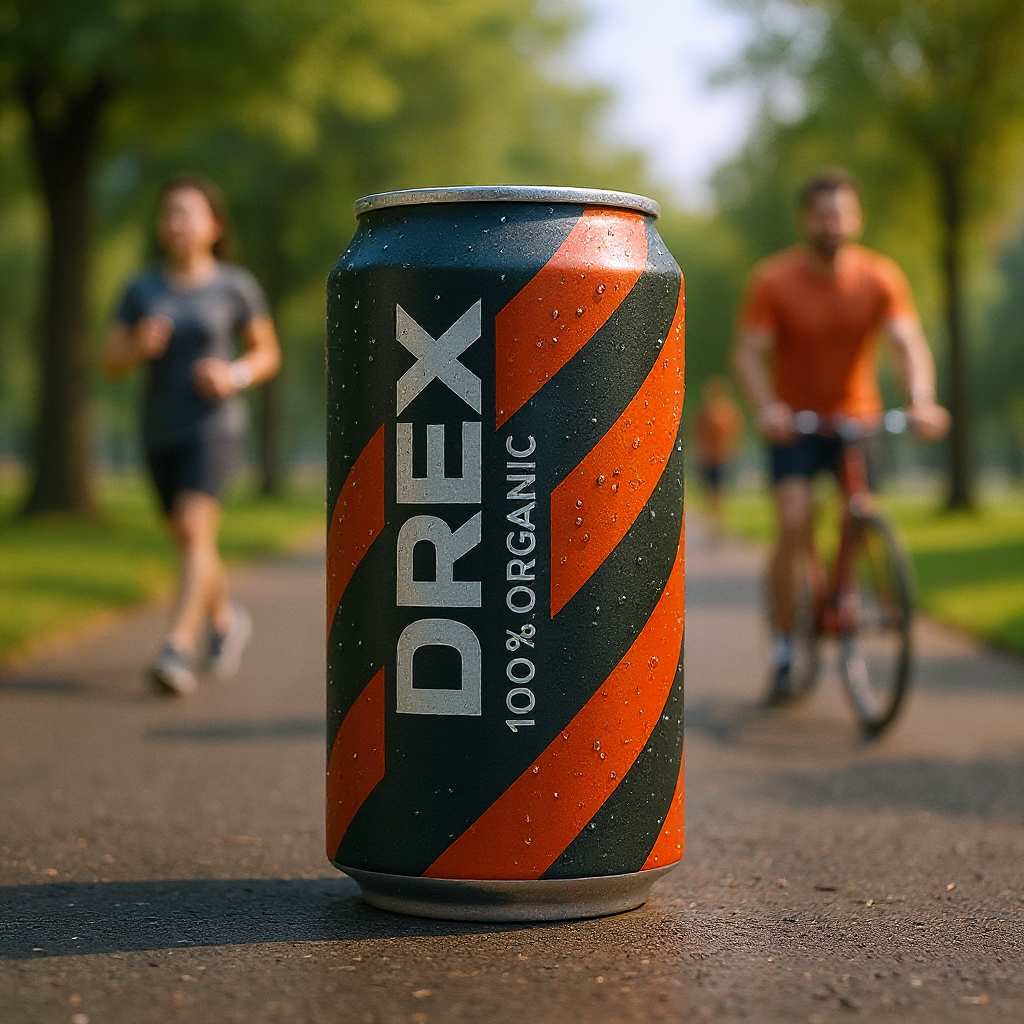


🎨 Generating image 2 with prompt:
In a serene natural setting, a Drex energy drink can is positioned prominently among fresh green leaves and dew-kissed grass, emphasizing its organic ingredients. Captured from a slightly elevated angle, the can’s reflection can be seen in a small pool of water beside it, adding depth and a sense of purity. Soft, diffused morning light filters through the trees, highlighting the can and creating a serene ambiance. The background showcases a forest scene with towering trees and dappled sunlight, reinforcing the natural theme. The color palette blends earthy browns, fresh greens, and soft blues for a peaceful and invigorating vibe. The can is slightly off-center, drawing the viewer's eye into the lush environment.



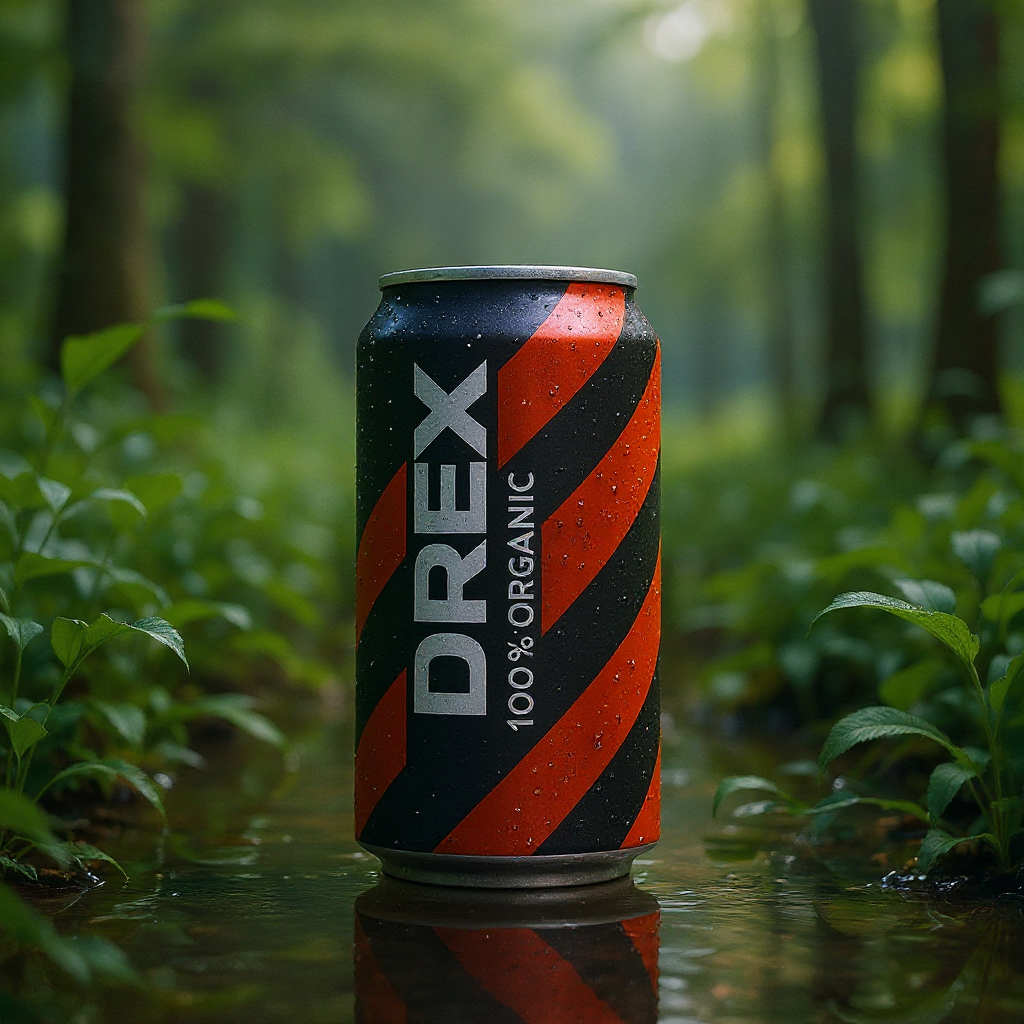


🎨 Generating image 3 with prompt:
A Drex energy drink can is placed on a sleek urban rooftop, overlooking a vibrant cityscape. The can, with its fresh and organic branding, catches the eye in the foreground, adorned with beads of condensation that suggest a cool, refreshing drink. Shot from a front-facing angle, the lighting is dynamic, with city lights twinkling in the background under a vibrant sunset sky. The color palette is a mix of rich oranges, deep blues, and the metallic sheen of the skyline, conveying an active and invigorating energy. The can is centered, capturing the viewer's attention amidst the bustling city backdrop.



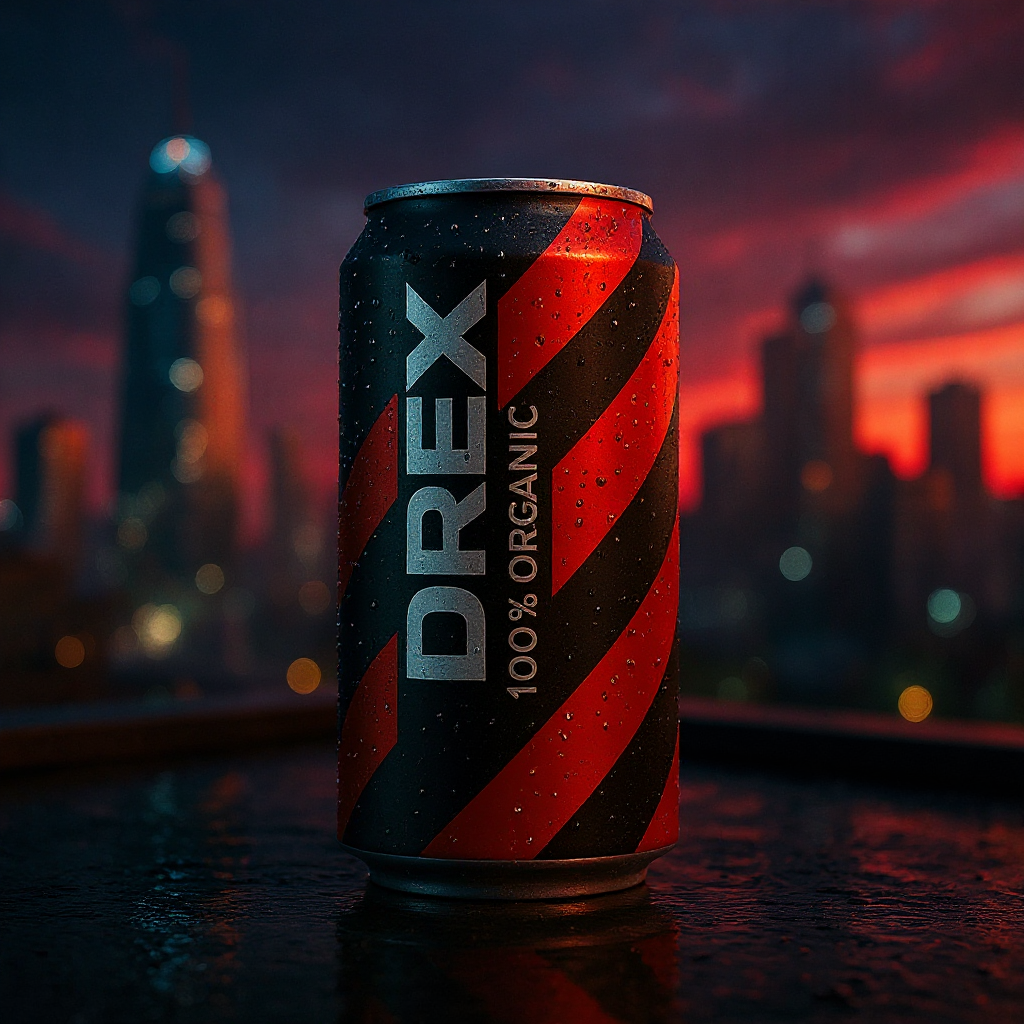

🎥 Uploading image for Scene 1 to FAL...
🚀 Submitting Scene 1 video request to Kling 2.1...


🎥 Uploading image for Scene 2 to FAL...
🚀 Submitting Scene 2 video request to Kling 2.1...


🎥 Uploading image for Scene 3 to FAL...
🚀 Submitting Scene 3 video request to Kling 2.1...


[Event] author=campaign_content_creator final=False
📤 [TOOL RETURN]: {'result': '✅ Successfully generated and saved all 3 images from Flux Pro.'}
📤 [TOOL RETURN]: {'result': '✅ Successfully generated and saved all 3 videos from Kling 2.1.'}
[Event] author=campaign_content_creator final=False
🔍 Detecting video resolutions...
Target resolution: 1440x1440
✅ All videos have same resolution - simple concat
🎬 Running ffmpeg concatenation...


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --

[Event] author=campaign_content_creator final=False
📤 [TOOL RETURN]: {'result': '✅ Successfully concatenated video at /Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/concatenated_video.mp4 (resolution: 1440x1440)'}
[Event] author=campaign_content_creator final=False

🧠 Summarizing scenes into Lyria-compatible prompt...

🎼 Generating music with Lyria 2...
Prompt:
 Create a 30s soundtrack blending ambient electronic and soft acoustic elements. Capture an ethereal and refreshing mood with gentle synth pads and light acoustic guitar strums. Use a moderate tempo to evoke a sense of calm vitality. Enhance with subtle nature and urban soundscapes for an immersive atmosphere.
[Event] author=campaign_content_creator final=False
📤 [TOOL RETURN]: {'result': '✅ Music successfully generated and saved at /Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/lyria_output.wav'}
[Event] author=campaign_content_creator final=False


ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.6)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.1.1_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --

[Event] author=campaign_content_creator final=False
📤 [TOOL RETURN]: {'result': '✅ Final video with audio is created and saved at /Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/final_video_with_audio.mp4'}
[Event] author=campaign_content_creator final=True
[campaign_content_creator]: - The full set of prompts from step 1 has been successfully generated and stored.
[Event] author=campaign_content_approver final=True
✅ Found NEXT long-running function call: content_approval_form
🔍 campaign_content_approver completed - checking for pending approvals...
🎥 Video path from context: /Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/final_video_with_audio.mp4


HTML(value='<h3>Content Approval Required</h3>')

HTML(value='<p><i>Approval ID: <strong>approval_1750513227</strong></i></p>')

HTML(value='<p><i>Please review the generated content below and approve or reject for publishing.</i></p>')

HTML(value='\n        <div style="text-align: center; margin: 20px 0;">\n            <h4>📹 Generated Content P…

HTML(value="<div style='margin: 20px 0;'></div>")

Output()

🛑 Agent execution will now pause. Content Approval ID: approval_1750513227
[Event] author=campaign_content_approver final=False
📤 [TOOL RETURN]: {'status': 'pending', 'approval_id': 'approval_1750513227', 'message': 'Content approval form displayed. Agent execution paused until approval.', 'video_path': '/Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/final_video_with_audio.mp4'}
📋 NEW function response: status=pending, approval_id=approval_1750513227
🔧 Function: content_approval_form
🛑 SECOND approval detected! Agent execution paused again...
After reviewing above, call: await resume_workflow() again


In [61]:
await resume_workflow()

In [62]:
await resume_workflow()

Event from an unknown agent: system, event id: Ddek4Tt7
Event from an unknown agent: system, event id: Vagh6M2y


✅ Approval confirmed! Resuming workflow...
VIDEO CONTENT APPROVAL DETECTED
🎥 Content approved: /Users/jeny/Desktop/Jupyter/Google ADK/OnlineMarketing/final_video_with_audio.mp4
✅ Session state updated with approval using EventActions
🧹 Cleaning up global state for next approval...
✅ Global state cleaned - next approval will have fresh state
🔄 Resuming agent execution...
🔄 Processing resumed workflow events...
[Event] author=campaign_advisor final=True
[campaign_advisor]: With the content approved, you can now proceed to deploy the campaign assets across your chosen platforms. Here’s how you can execute the next steps:

### Deployment Plan

1. **Upload Content to Instagram and TikTok**:
   - **Instagram**: Post the images and videos on your Drex Instagram profile. Use engaging captions and relevant hashtags to increase visibility.
   - **TikTok**: Share the video content on TikTok, utilizing trending sounds and hashtags to enhance reach.

2. **Engage with Your Audience**:
   - Respond t